# 0.0 - Imports

In [2]:
import math
import json
import random
import pickle
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from boruta import BorutaPy
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.gridspec as gridspec
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder



import warnings
warnings.filterwarnings("ignore")

## 0.1 - Helper Functions

In [3]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)

def ml_error(model_name, y, yhat):
    
    mae = mean_absolute_error(y, yhat) 
    mape= mean_absolute_percentage_error(y, yhat)
    rmse= np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'model_name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def cramer_v(var_x, var_y):

    # builds contigency matrix (or confusion matrix)
    confusion_matrix_v = pd.crosstab(var_x, var_y).values

    # gets the sum of all values in the matrix
    n = confusion_matrix_v.sum()

    # gets the rows, cols
    r, k = confusion_matrix_v.shape

    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix_v)[0]

    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)

    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list=[]
    mape_list=[]
    rmse_list=[]
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print(f'\nKfold Number : {k}')
        # start and end date for validation
        validation_start_date = x_training['date'].max()-datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max()-datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date']<validation_start_date]
        validation = x_training[(x_training['date']>=validation_start_date) & (x_training['date']<=validation_end_date)]

        #trainig and validation dataset
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store the results
        mae_list.append(result['MAE'])
        mape_list.append(result['MAPE'])
        rmse_list.append(result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': round(np.mean(mae_list),2).astype(str) + '+/-' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': round(np.mean(mape_list),2).astype(str) + '+/-' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': round(np.mean(rmse_list),2).astype(str) + '+/-' + np.round(np.std(rmse_list),2).astype(str)},  index=[0])

## 0.2 - Bussiness Problem

# 1.0 - Data Colection

In [4]:
# Colecting the data
train_df = pd.read_csv('../data/raw/train.csv', low_memory=False)
test_df = pd.read_csv('../data/raw/test.csv', low_memory=False)
store_df = pd.read_csv('../data/raw/store.csv', low_memory=False)

# Merging Train data and Store data
df_raw = train_df.merge(store_df, on='Store', how='left')

In [5]:
# training data
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.1 - Rename the columns

In [8]:
# List old cols names
cols_old = df_raw.columns.to_list()

# Lambda function 
snakecase = lambda x : inflection.underscore(x)

# List of new cols name
cols_new = list(map(snakecase, cols_old))

# Rename
df_raw.columns = cols_new

## 1.2 - Data Dimension

In [9]:
print(f'Number of rows {df_raw.shape[0]}')
print(f'Number of rows {df_raw.shape[1]}')

Number of rows 1017209
Number of rows 18


# 2.0 - Data Cleaning

In [10]:
# Change columns date dtype to datetime
df_raw['date'] = pd.to_datetime(df_raw['date'])

In [11]:
# General Info
pd.DataFrame({'missing': df_raw.isna().mean(),
              'uniquesValues': df_raw.nunique(),
              'types': df_raw.dtypes},
              )

,missing,uniquesValues,types
store,0.000000,1115,int64
day_of_week,0.000000,7,int64
date,0.000000,942,datetime64[ns]
sales,0.000000,21734,int64
customers,0.000000,4086,int64
open,0.000000,2,int64
promo,0.000000,2,int64
state_holiday,0.000000,4,object
school_holiday,0.000000,2,int64
store_type,0.000000,4,object


## 2.1 - Missing Data - Fillout

In [12]:
# Listing the columns with missing values
missing_df = pd.DataFrame({'missing': df_raw.isna().mean()}).sort_values(by='missing',ascending=False)
missing_df[missing_df['missing']>0].index.to_list()

['promo_interval',
 'promo2_since_year',
 'promo2_since_week',
 'competition_open_since_year',
 'competition_open_since_month',
 'competition_distance']

In [13]:
%%time
# competition_distance - Probably the NAs values are store that dont have a near competition or its to far lets fill them with a high number
df_raw['competition_distance'] = df_raw['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) else x )

# competition_open_since_month - Lets fill with the month of column date in this way we will be able to calculate(Feature Engineering) time related variables from it.
df_raw['competition_open_since_month'] = df_raw.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df_raw['competition_open_since_year'] = df_raw.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

#  promo2_since_week
df_raw['promo2_since_week'] = df_raw.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df_raw['promo2_since_year'] = df_raw.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1:'Jan', 2:'Fev',3:'Mar',4:'Abr',5:'Mai',6:'Jun',7:'Jul',8:'Ago',9:'Set',10:'Out',11:'Nov',12:'Dez',}

df_raw['promo_interval'].fillna(0, inplace=True)
df_raw['month_map'] = df_raw['date'].dt.month.map(month_map)

df_raw['is_promo'] = df_raw[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

CPU times: user 58.1 s, sys: 1.17 s, total: 59.3 s
Wall time: 59.3 s


## 2.2 - Change Dtypes

In [14]:
# checking the dtypes
df_raw.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
# competition_open_since variabels
df_raw['competition_open_since_month'] = df_raw['competition_open_since_month'].astype(int)
df_raw['competition_open_since_year'] = df_raw['competition_open_since_year'].astype(int)

# promo2_since variables
df_raw['promo2_since_week'] = df_raw['promo2_since_week'].astype(int)
df_raw['promo2_since_year'] = df_raw['promo2_since_year'].astype(int)

In [16]:
df_raw.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.3 - Data Description

In [17]:
# Numerical variables
num_att = df_raw.select_dtypes(include = ['int', 'float'])

# Categorical variables
cat_att = df_raw.select_dtypes(exclude = ['int', 'float', 'datetime64[ns]'])

### 2.3.1 - Numerical Attributes

In [18]:
# Central Tendency - mean, median

# Dispertion - std, min, max, range, skew, kurtosis
pd.DataFrame({'min': num_att.min(),
              'max': num_att.max(),
              'range':num_att.max() - num_att.min(), 
              'mean':num_att.mean(),
              'median':num_att.median(),
              'std': num_att.std(),
              'skew': num_att.skew(),
              'kurtosis': num_att.kurt()}).T

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000,200000.000000,12.000000,2015.000000,1.000000,52.000000,2015.000000,1.000000
range,1114.000000,6.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000,199980.000000,11.000000,115.000000,1.000000,51.000000,6.000000,1.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647,5935.442677,6.786849,2010.324840,0.500564,23.619033,2012.793297,0.083656
median,558.000000,4.000000,5744.000000,609.000000,1.000000,0.000000,0.000000,2330.000000,7.000000,2012.000000,1.000000,22.000000,2013.000000,0.000000
std,321.908651,1.997391,3849.926175,464.411734,0.375539,0.485759,0.383056,12547.652996,3.311087,5.515593,0.500000,14.310064,1.662658,0.276872
skew,-0.000955,0.001593,0.641460,1.598650,-1.758045,0.487838,1.677842,10.242344,-0.042076,-7.235657,-0.002255,0.178723,-0.784436,3.007488
kurtosis,-1.200524,-1.246873,1.778375,7.091773,1.090723,-1.762018,0.815154,147.789712,-1.232607,124.071304,-1.999999,-1.184046,-0.210075,7.044998


<AxesSubplot:xlabel='competition_open_since_year', ylabel='Density'>

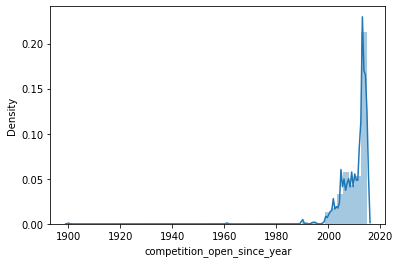

In [19]:
# checking distribution
sns.distplot(df_raw['competition_open_since_year'])

### 2.3.2 - Categorical Attributes

In [20]:
# Checking levels
cat_att.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

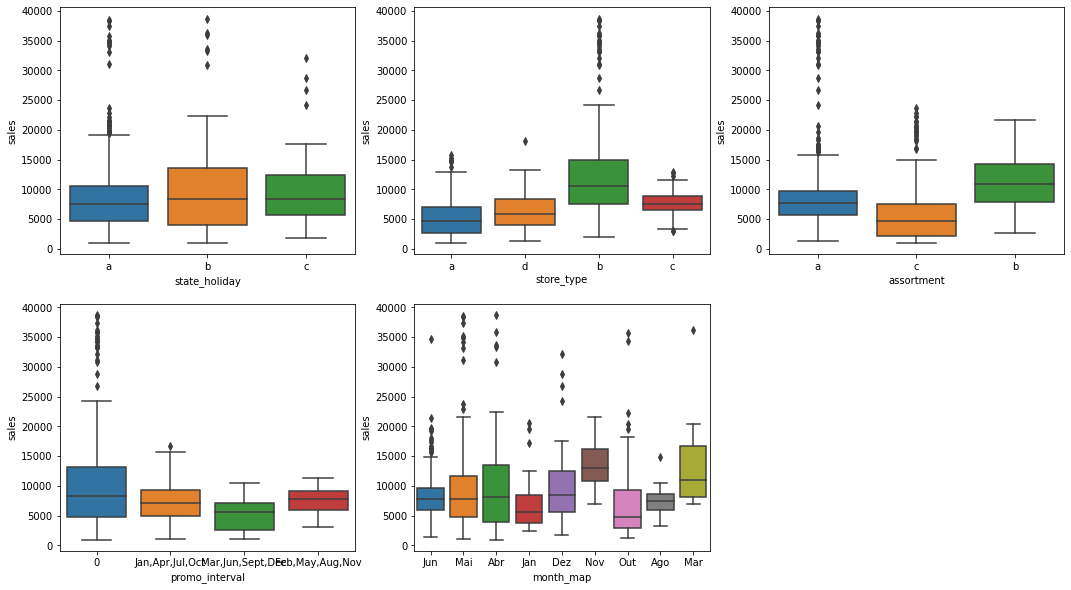

In [21]:
# df Aux
aux1 = df_raw[ (df_raw['state_holiday'] != '0') & (df_raw['sales'] > 0)]

# PLotting Box PLots
atts = cat_att.columns.to_list()

i=1 
plt.figure(figsize=(18,10))
for att in atts:
    plt.subplot(2,3, i )
    sns.boxplot(x=att, y='sales', data=aux1)
    i += 1

# 3.0 - Hypothesis Map

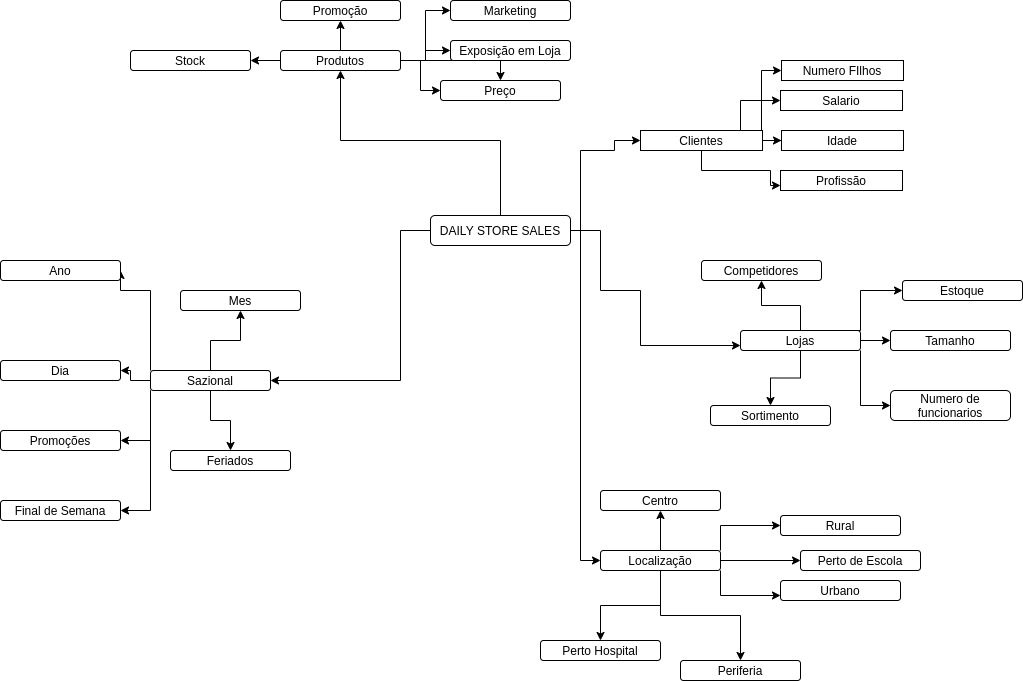

In [22]:
# Fenômeno, Agente, Atributos dos Agentes
path = '../reports/figures/rossman_hypoMap.png'
Image(path)

## Lista de Hipoteses

### Hipoóteses Loja


- Lojas com maior quadro de funcionários deveriam vender mais
- Lojas com maior estoque vendem mais.
- Lojas com maior porte  vendem mais.
- Lojas com maior sortimentos deveriam vender mais
- Lojas com competidores mais próximos deveriam vender mais
- Lojas com competidores a mais tempo deveriam vender mais

### Hipósteses Produto

- Lojas que investem mais em Marketing deveriam vender mais.
- Lojas que expoe mais o produtos nas vitrines deveriam vender mais.
- Lojas tem preços menores deveriam vender mais.
- Lojas com promoções mais agressivas(descontos maiores), deveriam vender mais
- Lojas com promoções ativas por mais tempo deveriam vender mais.
- Lojas com mais dias de promoção deveriam vender mais
- Lojas com mais promoções consecutivas deveriam vender mais.

### Hipóteses Tempo

 - Lojas abertas durante o feriado de Natal deveriam vender mais.
 - Lojas deveriam vender mais ao longo dos anos.
 - Lojas deveriam vender mais mais no segundo semestre do ano.
 - Lojas deveriam vender mais depois do dia 10 de cada mês.
 - Lojas deveriam vender menos aos finais de semana.
 - Lojas deveriam vender menos durante os feriados escolares.

### Lista Final

- Lojas com maior sortimentos deveriam vender mais
- Lojas com competidores mais próximos deveriam vender mais
- Lojas com competidores a mais tempo deveriam vender mais
- Lojas com promoções ativas por mais tempo deveriam vender mais.
- Lojas com mais dias de promoção deveriam vender mais
- Lojas com mais promoções consecutivas deveriam vender mais.
- Lojas abertas durante o feriado de Natal deveriam vender mais.
- Lojas deveriam vender mais ao longo dos anos.
- Lojas deveriam vender mais mais no segundo semestre do ano.
- Lojas deveriam vender mais depois do dia 10 de cada mês.
- Lojas deveriam vender menos aos finais de semana.
- Lojas deveriam vender menos durante os feriados escolares.

# 4.0 - Feature Engineering

In [23]:
df_feat = df_raw.copy()

In [24]:
# Variaveis que seram criadas

# year
df_feat['year'] = df_feat['date'].dt.year

# month
df_feat['month'] = df_feat['date'].dt.month

# day
df_feat['day'] = df_feat['date'].dt.day

# week of year
df_feat['week_of_year'] = df_feat['date'].dt.isocalendar().week

# year week
df_feat['year_week'] = df_feat['date'].dt.strftime('%Y-%W')

# competition since
df_feat['competition_since'] = df_feat.apply(lambda x : datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'] , day=1 ), axis=1)
df_feat['competition_time_month']=((df_feat['date'] - df_feat['competition_since'])/30).apply(lambda x: x.days).astype('int')

# promo since
df_feat['promo_since'] = df_feat['promo2_since_year'].astype(str) + '-' + df_feat['promo2_since_week'].astype(str) 
df_feat['promo_since'] = df_feat['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df_feat['promo_time_week'] = ((df_feat['date'] - df_feat['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df_feat['assortment']=df_feat['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df_feat['state_holiday']=df_feat['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [25]:
df_feat.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 4.1 - Feature Selection - Negócios

In [26]:
df3 = df_feat.copy()

### 4.1.1 Filtragem das Linhas

In [27]:
# open != 0
# sales > 0

In [28]:
df3 = df3.loc[(df3['open'] != 0) & (df3['sales']>0), :]

### 4.1.2 Seleção de Colunas

In [29]:
#'customers' - Modelo em separado para prever a quantidade de clientes daqui a 6 meses, sem isso não conseguimos usar
cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 5.0 - EDA (Análise Exploratoria)

In [31]:
df4 = df3.copy()

## 5.1 - Analise Univariada

### 5.1.1 - Response Variable

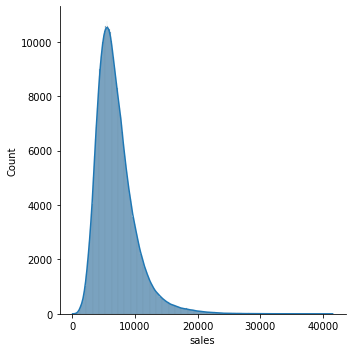

In [32]:
sns.displot(df4['sales'], kde=True)

### 5.1.2 - Numerical Variables

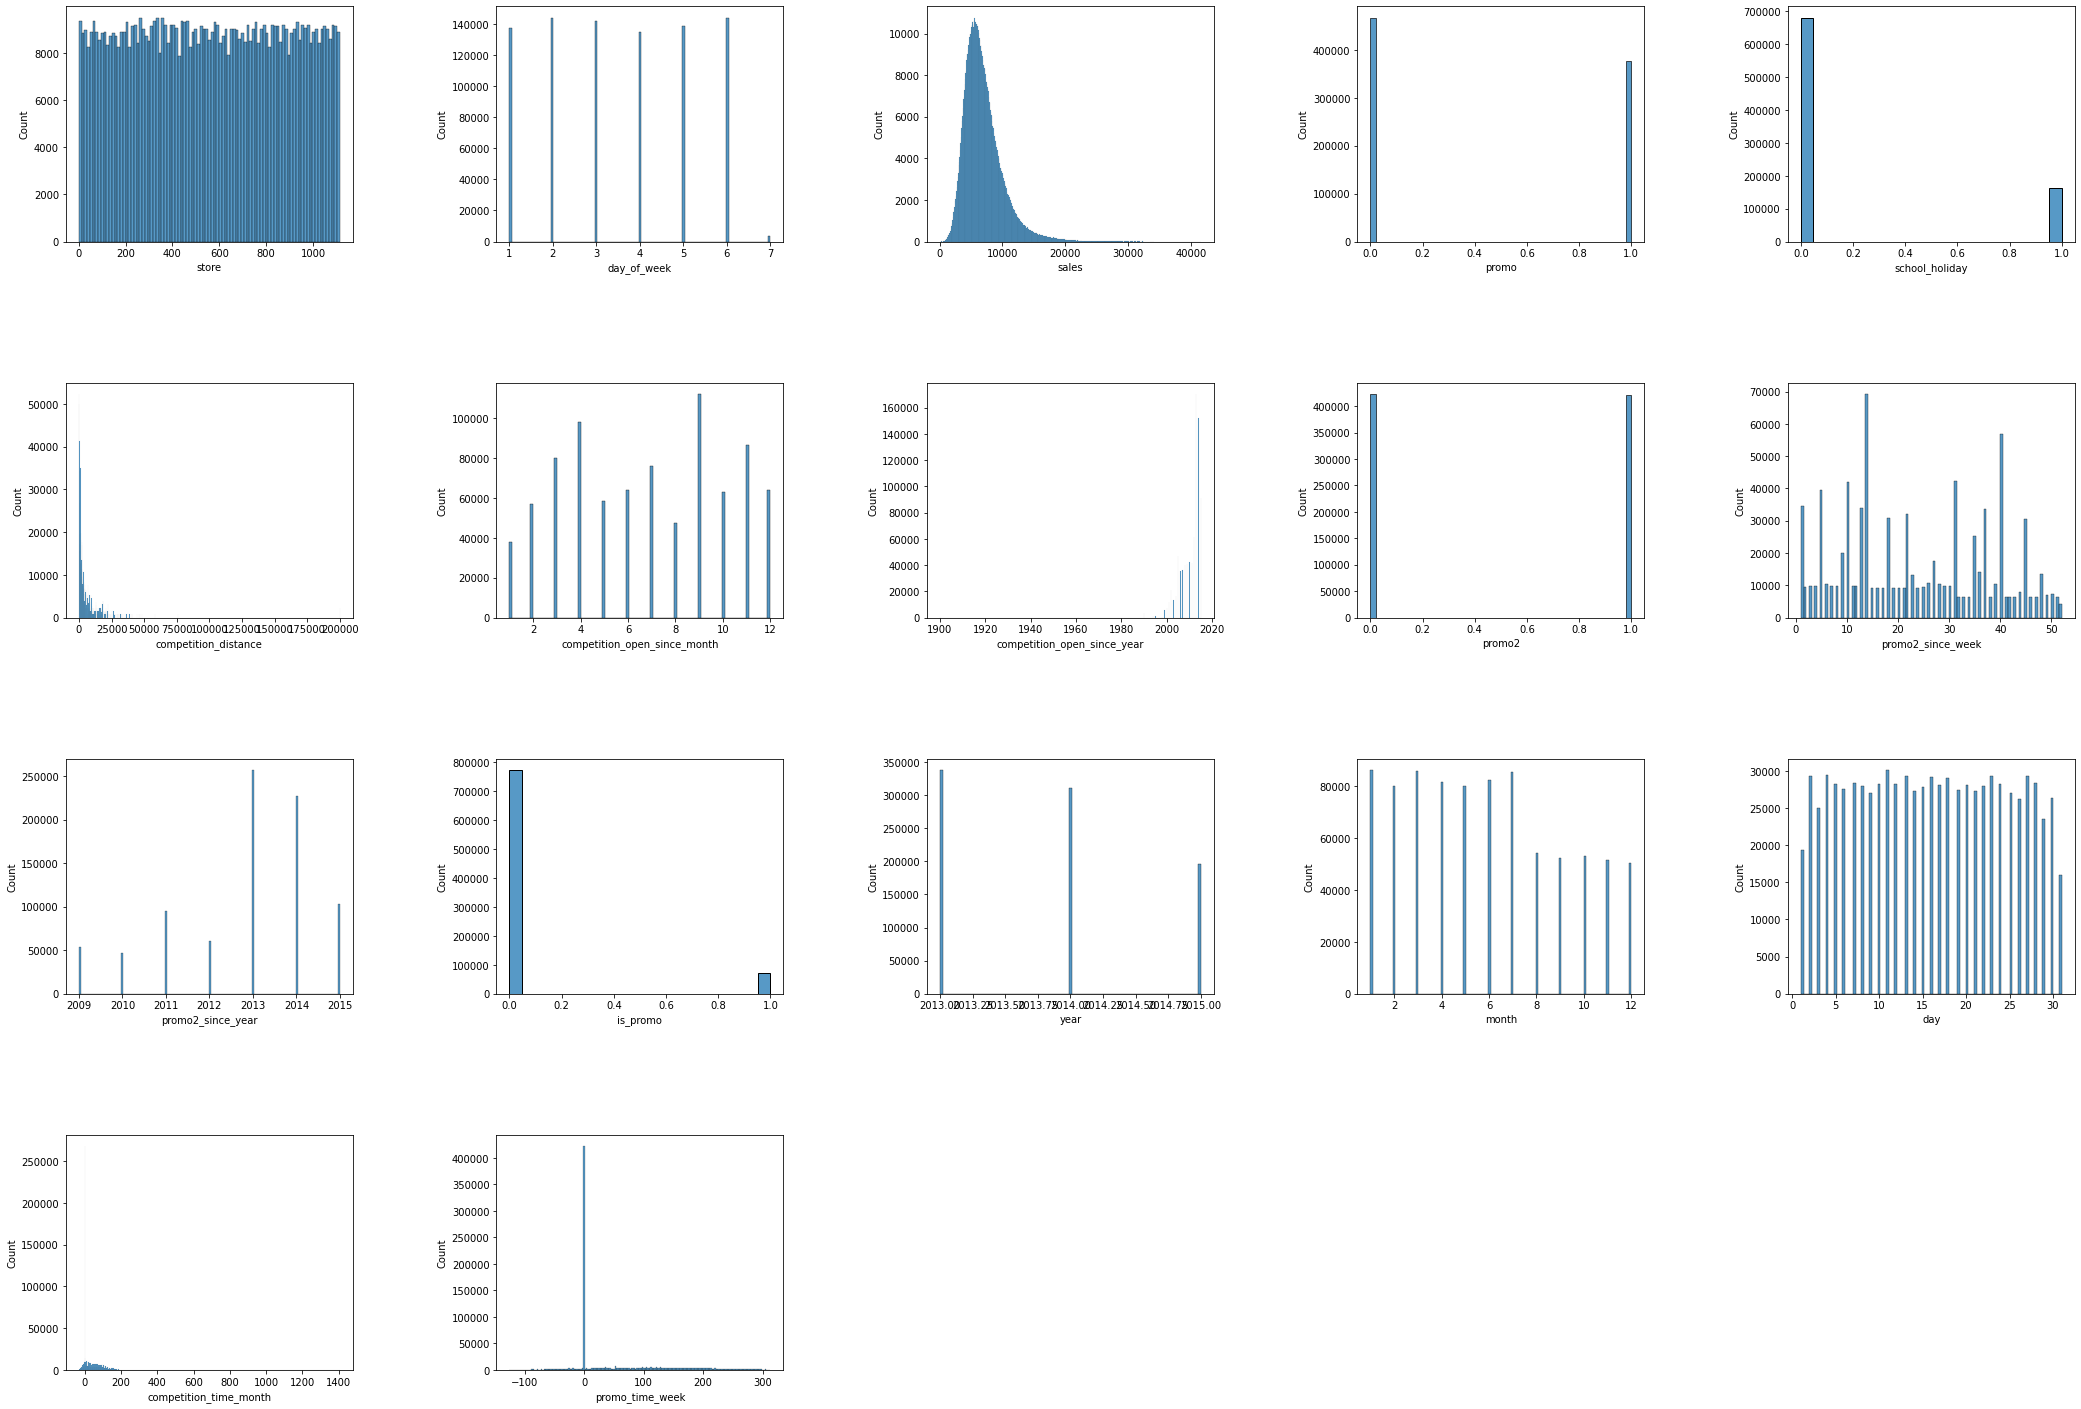

In [33]:
num_att = df4.select_dtypes(include=['int64', 'float64'])

# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in num_att.columns.to_list():
    plt.subplot(5, 5, n)
    sns.histplot(x=column, data=num_att)
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

## 5.1.2 - Variáveis Categoricas

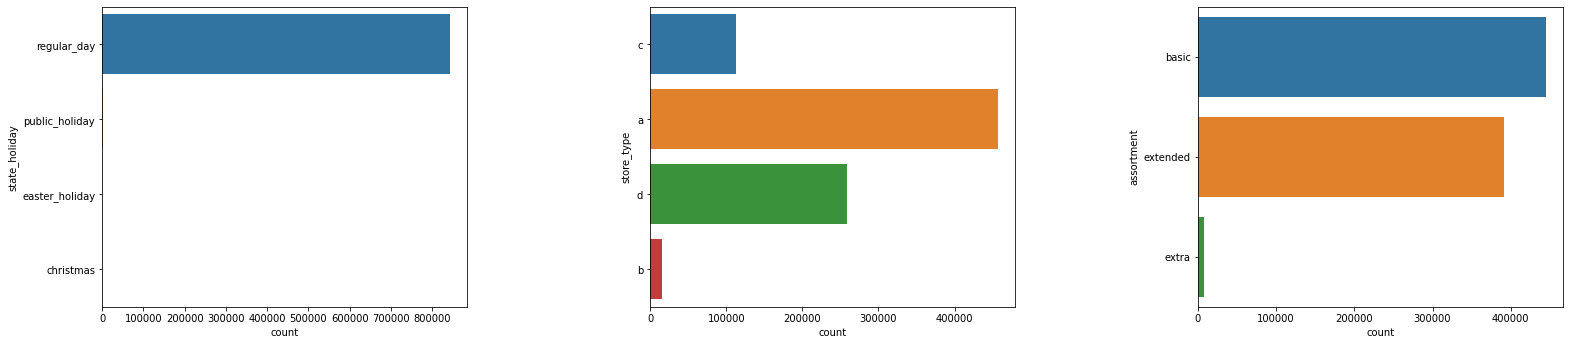

In [34]:
# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in df4[['state_holiday', 'store_type', 'assortment']].columns.to_list():
    plt.subplot(4, 4, n)
    sns.countplot(y=column, data=df4[['state_holiday', 'store_type', 'assortment']])
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

### 5.1.4 - state_holiday

In [35]:
temp = df4[['state_holiday', 'store_type', 'assortment']]
temp = temp[temp['state_holiday'] != 'regular_day']

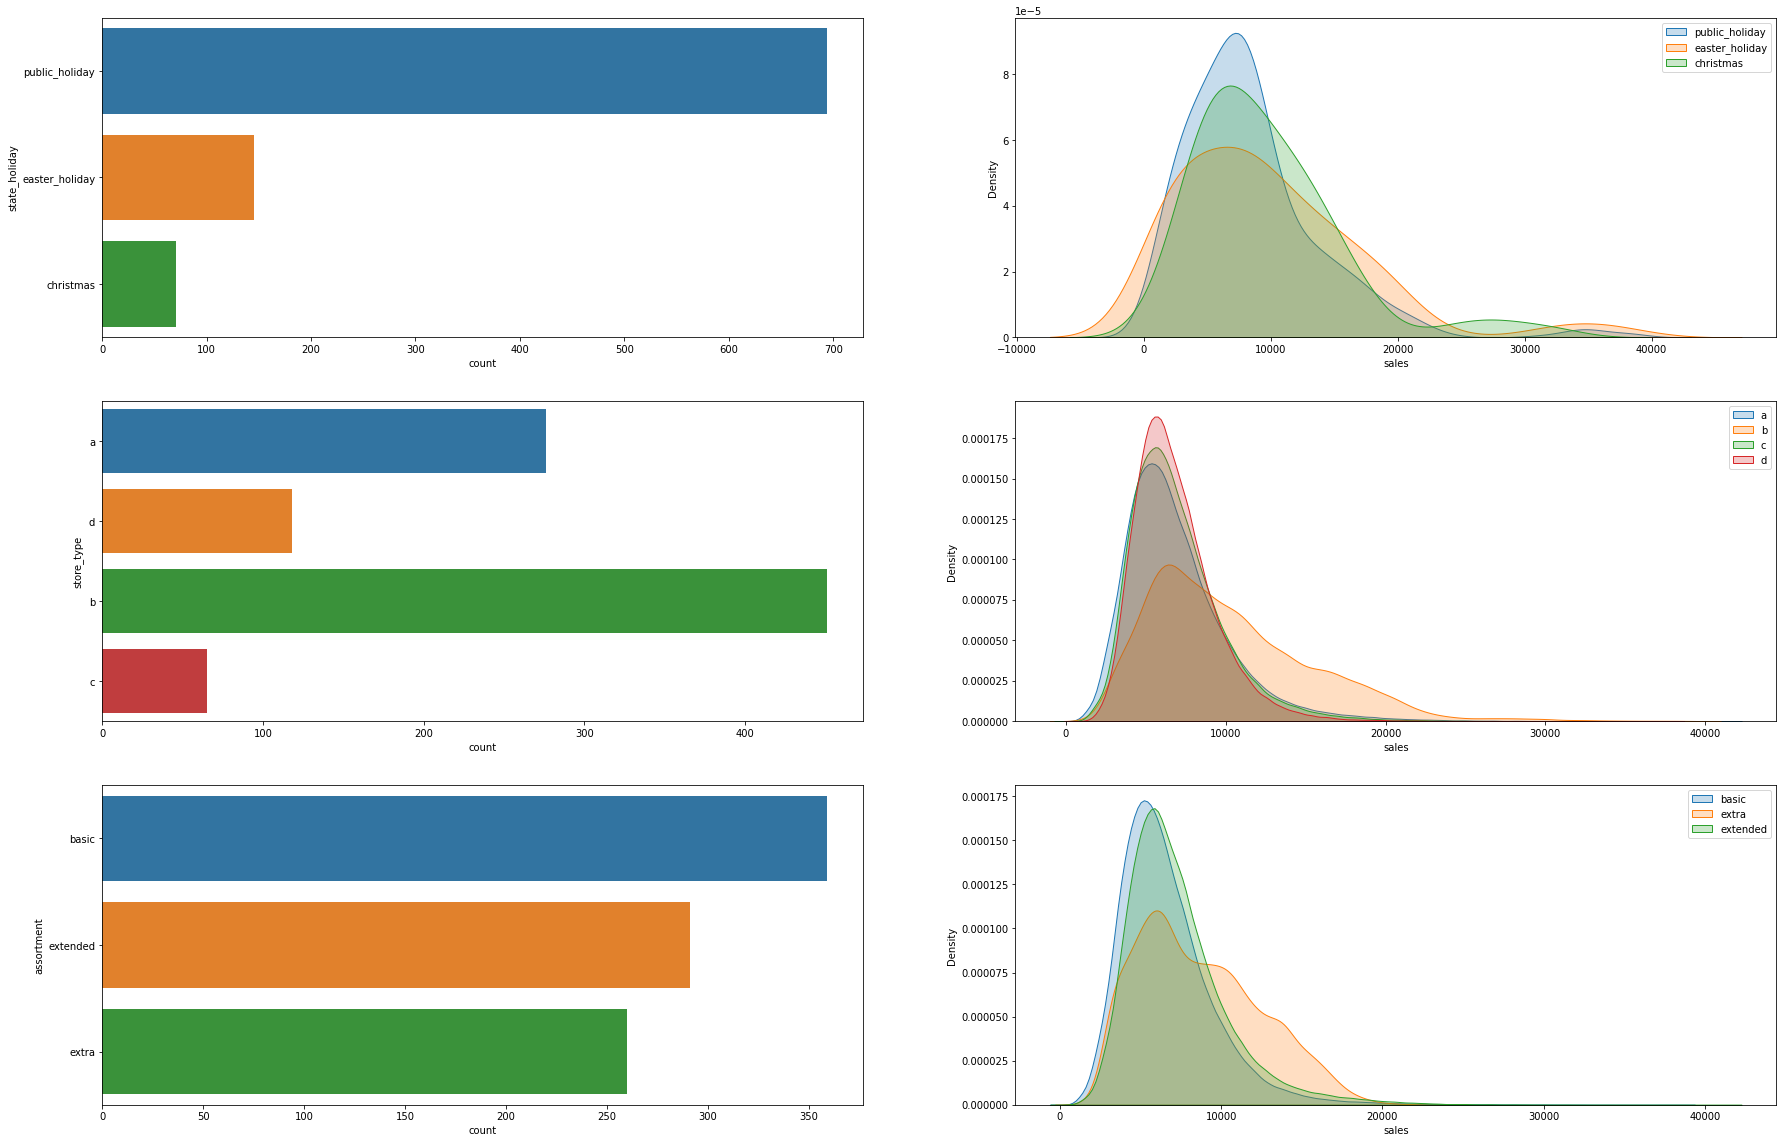

In [36]:
plt.figure(figsize=(30, 20))

# state_holiday
plt.subplot(3,2,1)

sns.countplot(y='state_holiday', data=temp)

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], label='christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(y='store_type', data=temp)


plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(y='assortment', data=temp)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label='extra', shade=True)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label='extended', shade=True)
plt.legend()

## 5.2 - Análise Bivariada

### H1 - Lojas com maior sortimentos deveriam vender mais. - assortment, sales [False]

Lojas com assortment extra, possuem o menor volume de vendas.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

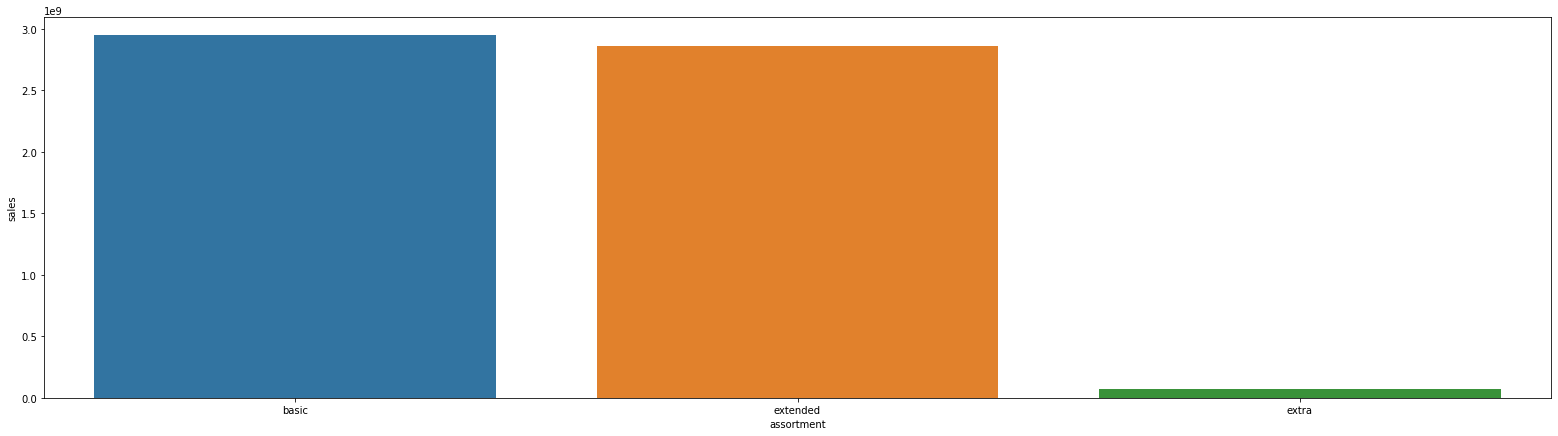

In [37]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
plt.figure(figsize=(27,7))
sns.barplot(x='assortment', y='sales', data=aux1)

<AxesSubplot:xlabel='year_week'>

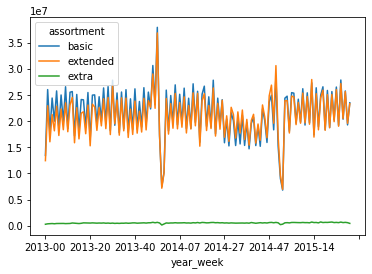

In [38]:
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week' ,columns='assortment' , values='sales').plot()

<AxesSubplot:xlabel='year_week'>

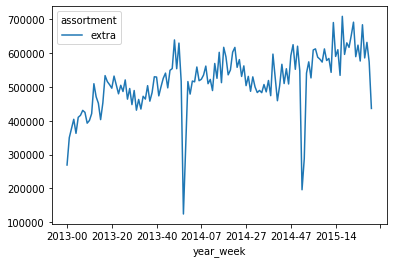

In [39]:
aux2 = aux2[aux2['assortment']=='extra']
aux2.pivot(index='year_week' ,columns='assortment' , values='sales').plot()

### H2 - Lojas com competidores mais próximos deveriam vender mais [False]
Lojas com competidores proximos vendem mais.



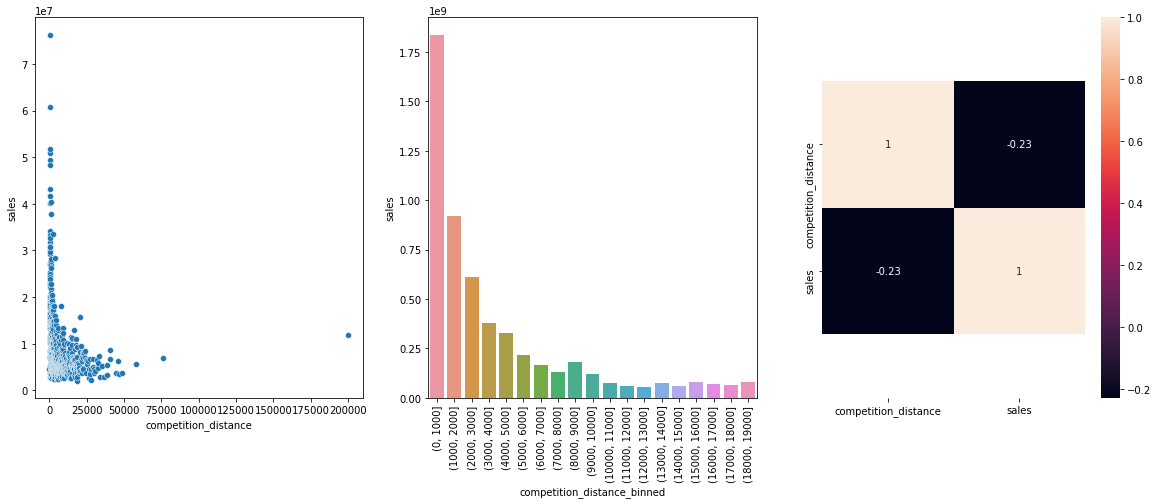

In [40]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.figure(figsize=(20,7))
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H3 - Lojas com competidores a mais tempo deveriam vender mais [Falsa]
Lojas com competidores a mais tempo vendem Menos.


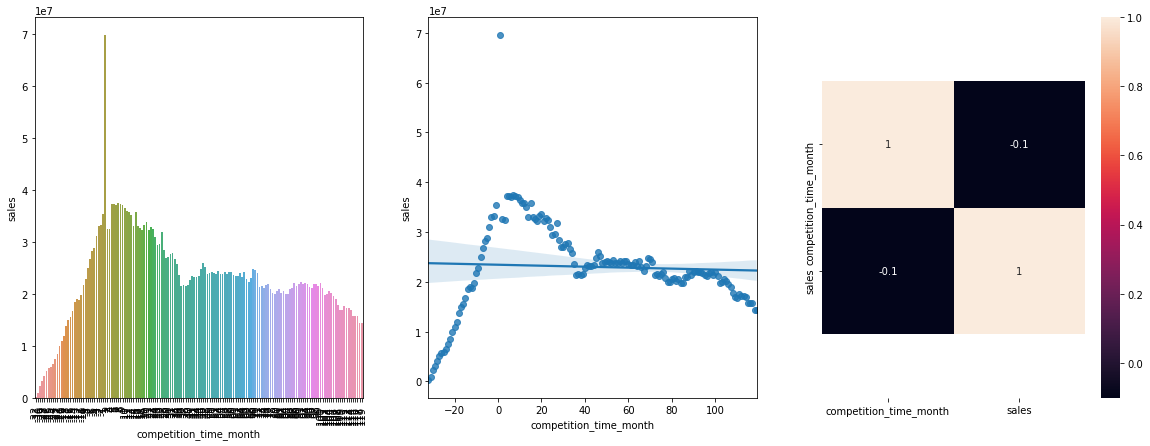

In [41]:
plt.figure(figsize=(20,7))
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### H4 - Lojas com promoções ativas por mais tempo deveriam vender mais [Falsa]
Lojas com promoções ativas a mais tempo vendem menos, depois de um certo periodo de promoção.

In [42]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Separando o periodo de promoção extendido e regular
aux2 = aux1[aux1['promo_time_week']>0]
aux3 = aux1[aux1['promo_time_week']<0]

<AxesSubplot:>

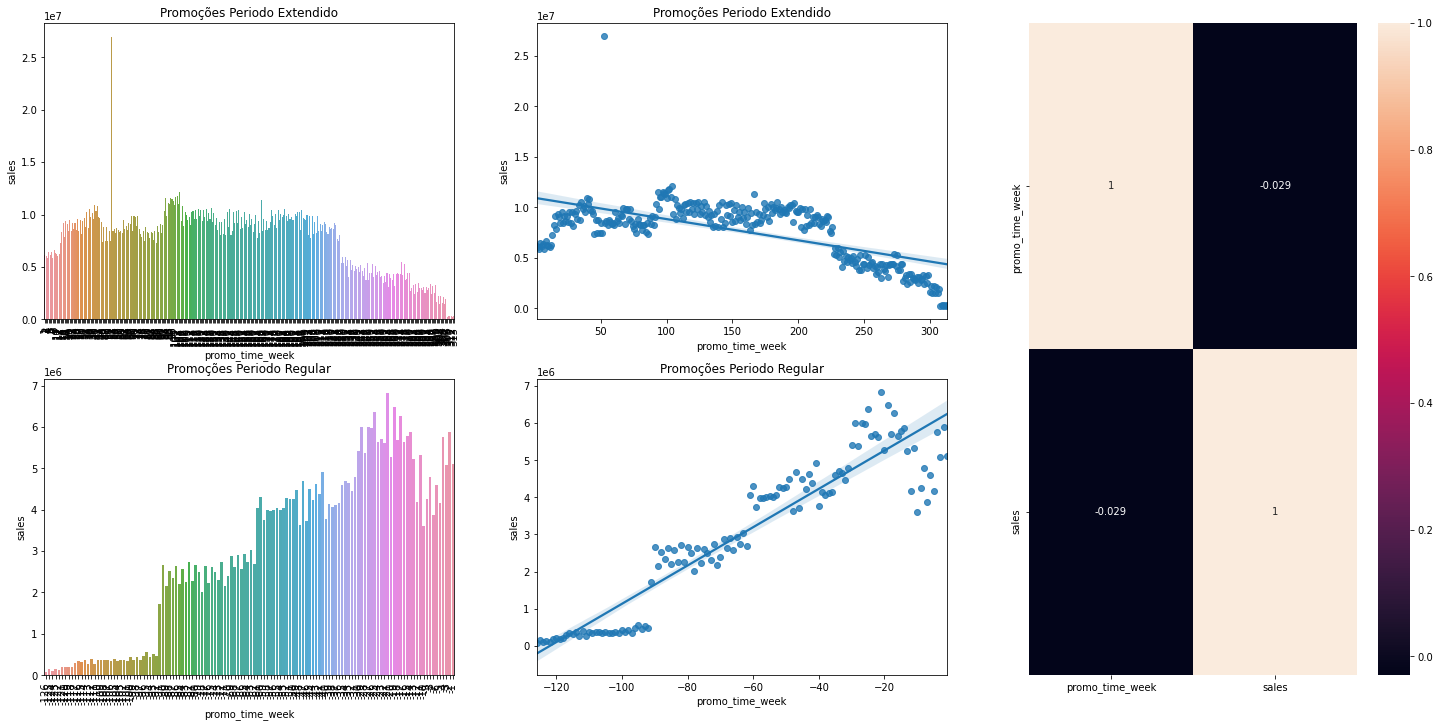

In [43]:
# Plot
plt.figure(figsize=(25,12))
grid =  gridspec.GridSpec(2, 3)

# Barplot
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales',data=aux2)
plt.xticks(rotation=90)
plt.title('Promoções Periodo Extendido')

# Regplot
plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales',data=aux2)
plt.title('Promoções Periodo Extendido')

# Barplot
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales',data=aux3)
plt.xticks(rotation=90)
plt.title('Promoções Periodo Regular')

# Regplot
plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales',data=aux3)
plt.title('Promoções Periodo Regular')

# HeatMap
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

<s>H5 - Lojas com mais dias de promoção deveriam vender mais</s>

### H6 - Lojas com mais promoções consecutivas deveriam vender mais [Falsa]
Lojas com mais promoções consecutivas vendem menos

In [44]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


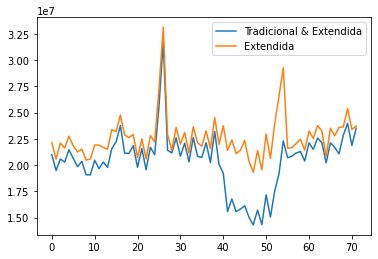

In [45]:
# Plot
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

###  H7 - Lojas abertas durante o feriado de Natal deveriam vender mais. [Falsa]
Lojas abertas durante o Natal não vendem mais.

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

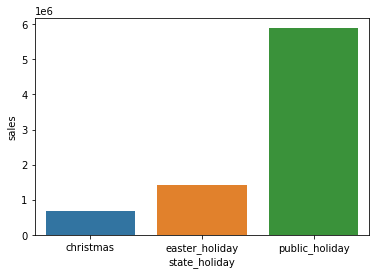

In [46]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

### H8 - Lojas deveriam vender mais ao longo dos anos. FALSA
Lojas vendem menos ao longo do ano

<AxesSubplot:>

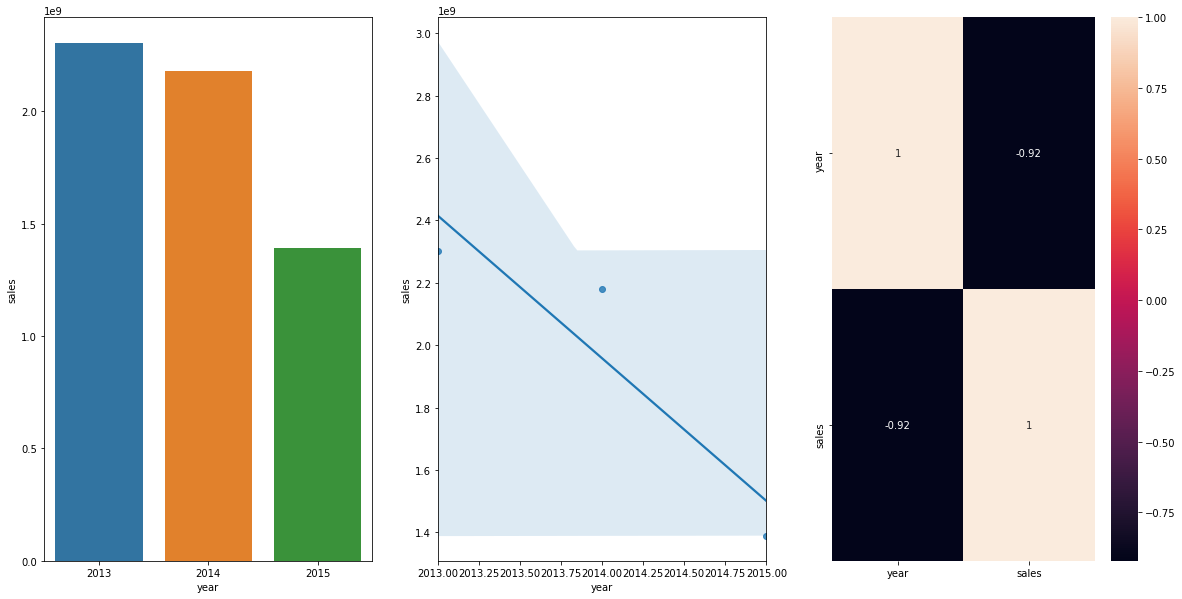

In [47]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H9 - Lojas deveriam vender mais mais no segundo semestre do ano.

<AxesSubplot:>

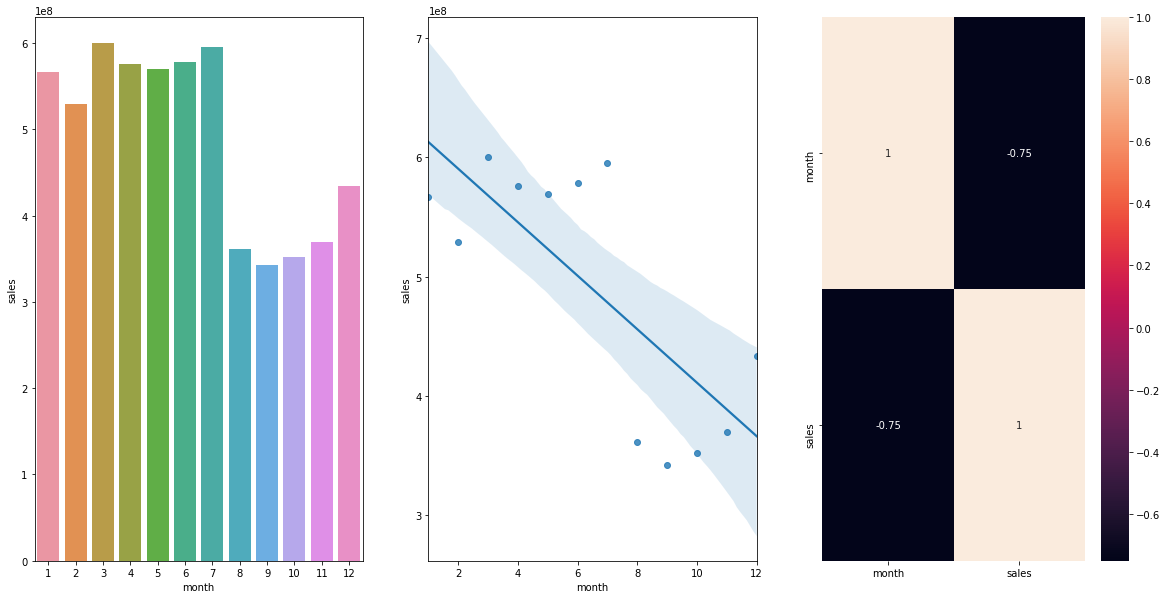

In [48]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês. VERDADEIRA
Lojas vendem mais depois dos 10 primeiros dias de cada mês

<AxesSubplot:xlabel='before_after', ylabel='sales'>

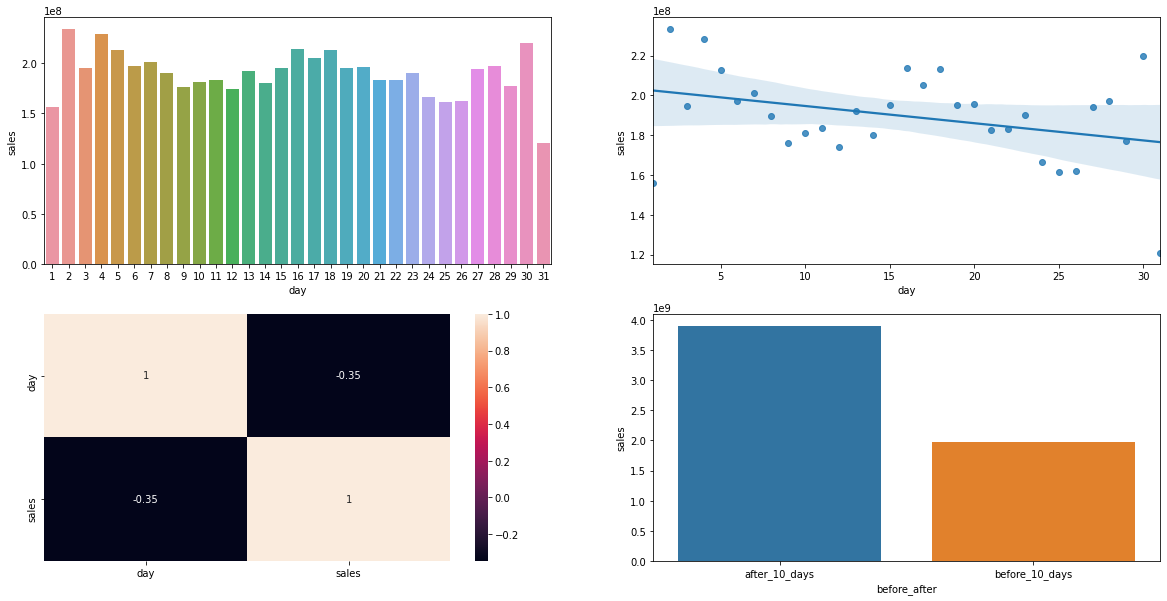

In [49]:
# Data
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()


# Plot
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2)

### H11 - Lojas deveriam vender menos aos finais de semana. VERDADEIRA
Lojas menos nos finais de semana

<AxesSubplot:>

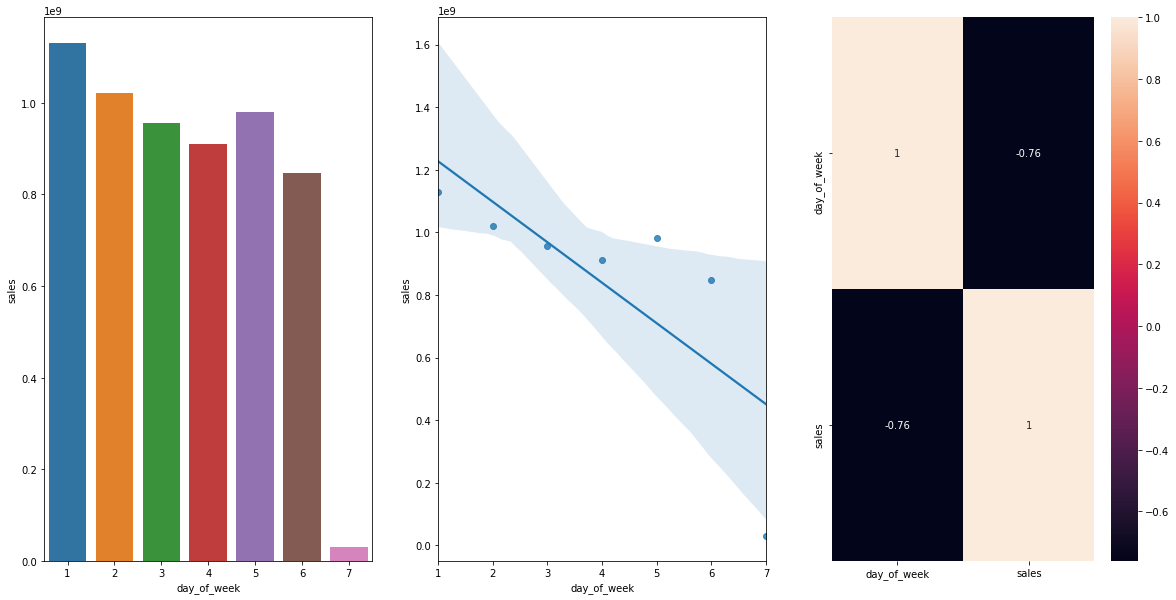

In [50]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H12 - Lojas deveriam vender menos durante os feriados escolares. VERDADEIRO
Lojas vendem menos durante feriados escolares. Except os meses de julho e agosto.

<AxesSubplot:xlabel='month', ylabel='sales'>

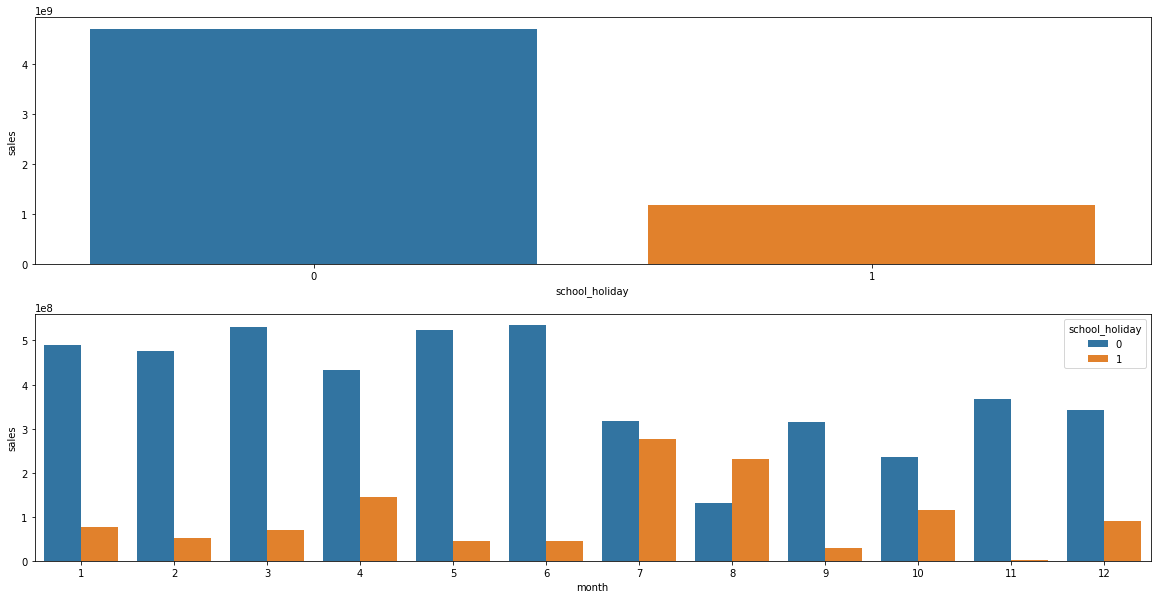

In [51]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()


plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue = 'school_holiday', data=aux2)

## Análise Multivariada

In [52]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

In [53]:
df4.head(2)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279


In [54]:
# Changing the type of 'week_of_year'
df4['week_of_year']=df4['week_of_year'].astype('int64')

## Numerical Atributes

<AxesSubplot:>

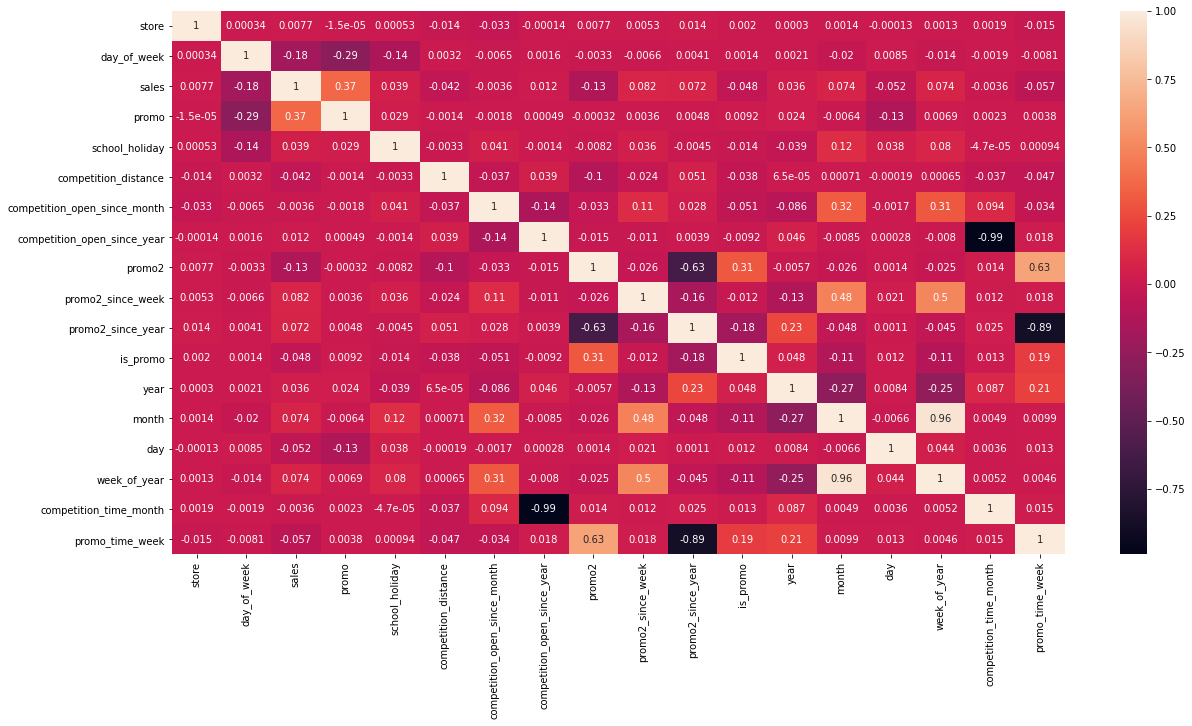

In [55]:
num_att = df4.select_dtypes(include=["int64","float64"])
corr = num_att.corr(method='pearson')

plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True)

## Categorical Attributes

Text(0.5, 1.0, 'Cramér V')

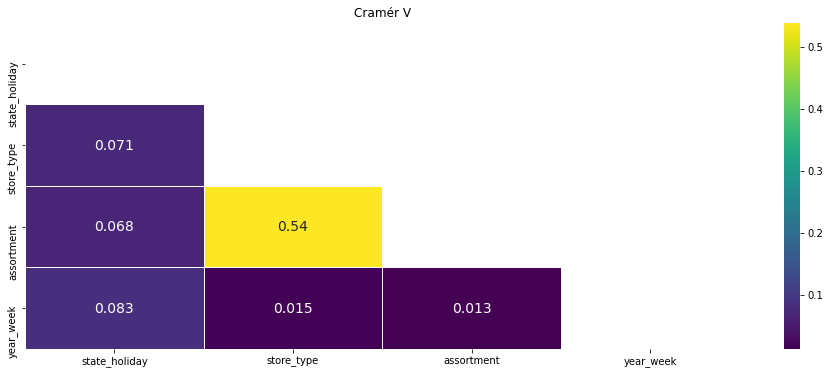

In [56]:
cat_att = df4.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])
cols = cat_att.columns.to_list()

# Dicionário para registro das correlações
dictt = {'state_holiday': [],
        'store_type':[],
        'assortment':[],
        'year_week':[]  }

for col in cols:
    for col1 in cols:
        corr = cramer_v(cat_att[col], cat_att[col1])
        dictt[col].append(corr)
        
# Matriz de Correlação
df_cramer1 = pd.DataFrame(dictt)
df_cramer1 = df_cramer1.set_index(df_cramer1.columns)

# HeatMap
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 6)

mask = np.triu(np.ones_like(df_cramer1, dtype=np.bool))
sns.heatmap(df_cramer1, mask=mask, linewidths=.5, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Cramér V")

# 6.0 - Preparação do Dados

In [57]:
df5 = df4.copy()

## Normalização - não realizada pois não havia features com distribuição normal.

## 6.1 - Rescaling

In [58]:
# MinMaxScaler / RobustScaler

rs = RobustScaler()
mms = MinMaxScaler(feature_range=(0,1))


a = df5.select_dtypes(include=['int64', 'float64'])
a.head(2)

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279


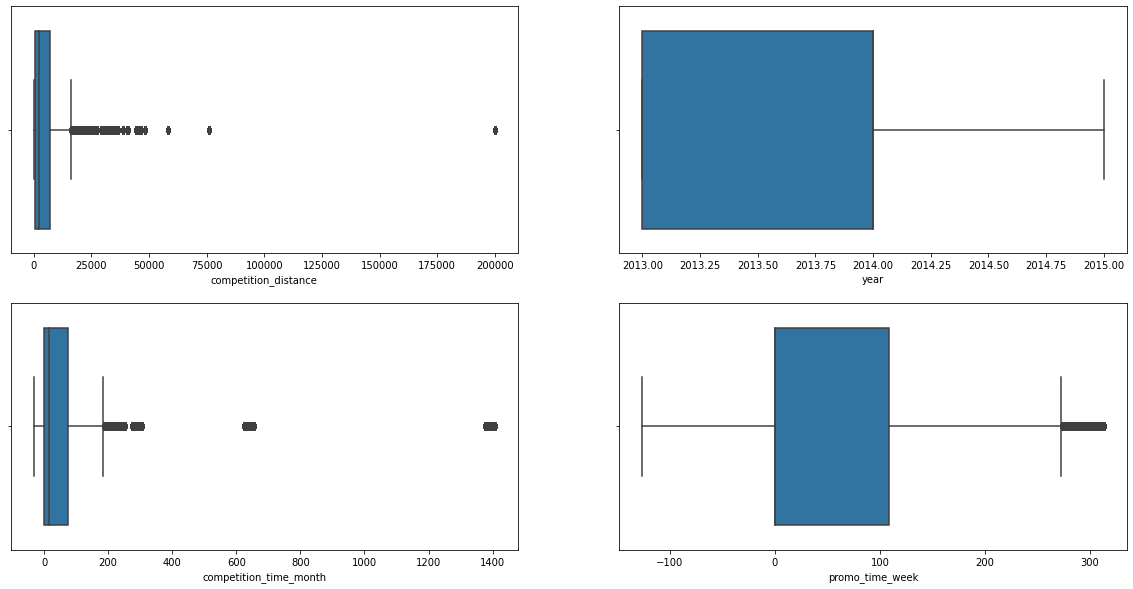

In [59]:
# Checking outliers

variaveis = ['competition_distance', 'year', 'competition_time_month', 'promo_time_week']

i=1
plt.figure(figsize=(20,10))

for var in variaveis:
    plt.subplot(2,2,i)
    sns.boxplot(df5[var])
    i+=1

In [60]:
# competition distance, competition time month, promo time week - RobustScaler
variaveis = ['competition_distance', 'competition_time_month', 'promo_time_week']

for var in variaveis:
    df5[var] = rs.fit_transform(np.array(df5[var]).reshape(-1,1))
    pickle.dump(rs, open(f'../parameters/{var}_scaler.pkl', 'wb'))

In [61]:
# year
df5['year'] = mms.fit_transform(np.array(df5['year']).reshape(-1,1))
pickle.dump(mms, open(f'../parameters/year_scaler.pkl', 'wb'))

## 6.2 - Transformação

One Hot Encoding - quando a variável categórica representa uma alteração de estado.

Label Encoding - quando não tem hierarquia entre as categorias

Oridnal Encoding - quando tem hierarquia entre as categorias

Target Encoding - quando a variável possui muitos niveis

Frequency Encoding - quando a variável possui muitos niveis

Embedding Encoding

### 6.2.1 - Encoding Categóricos

In [62]:
a = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
a.columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

In [63]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [64]:
df5.head(2)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.000000,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,2.559633,0,0,0,1


In [65]:
# store_type - Label Encoding
enc = LabelEncoder()
df5['store_type'] = enc.fit_transform(df5['store_type'])
pickle.dump(enc, open(f'../parameters/store_type_scaler.pkl', 'wb'))

In [66]:
# assortment - Ordinal Encoding
assortment_dict = {'basic' : 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [67]:
df5.head(2)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.000000,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,2.559633,0,0,0,1


### 6.2.2 - Response Variable Transformation

1. Logarithm Transformation

2. Box-Cox Transformation

3. Cube-Root Transformation

4. Square-Root Transformation

5. Sine and Cosine Transfomation

In [68]:
# response transf
df5['sales'] = np.log1p(df5['sales'])

### Nature Transformation

- day of week - ciclica

- month - ciclica

- day - ciclica

- week of year - ciclica

In [69]:
# Nature Transfomation due ciclical nature of variables
clic_vars = ['day_of_week', 'day', 'month', 'week_of_year']


for var in clic_vars:
    if var == 'month':
        df5[str(var)+'_sin'] = df5[var].apply( lambda x: np.sin(x *(2. * np.pi/12)))
        df5[str(var)+'_cos'] = df5[var].apply( lambda x: np.cos(x *(2. * np.pi/12)))
        
    elif var == 'day':
        df5[str(var)+'_sin'] = df5[var].apply( lambda x: np.sin(x *(2. * np.pi/30)))
        df5[str(var)+'_cos'] = df5[var].apply( lambda x: np.cos(x *(2. * np.pi/30)))
        
    elif var == 'day_of_week':
        df5[str(var)+'_sin'] = df5[var].apply( lambda x: np.sin(x *(2. * np.pi/7)))
        df5[str(var)+'_cos'] = df5[var].apply( lambda x: np.cos(x *(2. * np.pi/7)))
        
    else:
        df5[str(var)+'_sin'] = df5[var].apply( lambda x: np.sin(x *(2. * np.pi/52)))
        df5[str(var)+'_cos'] = df5[var].apply( lambda x: np.cos(x *(2. * np.pi/52)))

# 7.0 - Feature Selection

**Quadro Correlação Preditoras x Respostas**

Contínua | Contínua -   Correlação de Pearson

Contínua | Categórica - LDA

Categórica | Contínua - ANOVA

Categórica | Categórica - Chi-Square / Cramers v

### Seleção Univariada (Filter Methods)

**Vantagens**

- Método Simples.
- Método Rápido.
- Fácil Entimento.

**Desvatangens**

- Não considera a influência entre as variáveis.


### Seleção por Importância (Embedded Methods)

- É a variável que maior diminui a medida de de 'confusão' nos dados(gini, entropia) a partir do split.

### Seleção por Subset (Wrapper Methods)

**Seleção por Subset**

- Seleciona uma unica variável de forma aleatoria do dataset.

- Treina um modelo de ML

- Calcule a performance do Modelo

- A performance aumentou?
       - Se sim - Matém a variável
       - Se não - Remove a variável
       
**Borutha**

- Cria variaveis shadow(são as variáveis originas embaralhadas das linhas) das originais.
- Treina um modelo com o novo dataset e mede a importância de cada feature.
- Compara a importancia das variaveis originais com as shadow, se a importancia da variavel original for maior que a mais importante do conjunto shadow essa var recebe 1 em uma tabela if not 0.
- repeat, até ter uma tabela de sucesso
- Usa a Dist, Binomial para calcular o p-value sobre a tabela if var > p-value-threshold var fica if not é retirada.

In [70]:
df6 = df5.copy()

In [71]:
df6.isna().mean()

store                           0.0
day_of_week                     0.0
date                            0.0
sales                           0.0
promo                           0.0
school_holiday                  0.0
store_type                      0.0
assortment                      0.0
competition_distance            0.0
competition_open_since_month    0.0
competition_open_since_year     0.0
promo2                          0.0
promo2_since_week               0.0
promo2_since_year               0.0
is_promo                        0.0
year                            0.0
month                           0.0
day                             0.0
week_of_year                    0.0
year_week                       0.0
competition_since               0.0
competition_time_month          0.0
promo_since                     0.0
promo_time_week                 0.0
state_holiday_christmas         0.0
state_holiday_easter_holiday    0.0
state_holiday_public_holiday    0.0
state_holiday_regular_day   

## 7.1 - Split dataframe into training and test dataset

In [72]:
# dropping original vars
cols_drop =["week_of_year","day","month","day_of_week", "promo_since", "competition_since", "year_week"]
df6 = df6.drop(cols_drop, axis=1)

In [73]:
# descobrir a datalimite para os dados de treino e teste
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7)

Timestamp('2015-06-19 00:00:00')

In [74]:
# Training dataset
Xtrain = df6[df6['date'] < '2015-06-19']
ytrain = Xtrain['sales']

# Test dataset
Xtest = df6[df6['date'] > '2015-06-19']
ytest = Xtest['sales']

min_data = Xtrain['date'].min()
max_data = Xtrain['date'].max()
print(f' Training Min Data:  {min_data}')
print(f' Training Max Data:  {max_data}')

min_data = Xtest['date'].min()
max_data = Xtest['date'].max()
print(f'\n Test Min Data:  {min_data}')
print(f' Test Max Data:  {max_data}')

 Training Min Data:  2013-01-01 00:00:00
 Training Max Data:  2015-06-18 00:00:00

 Test Min Data:  2015-06-20 00:00:00
 Test Max Data:  2015-07-31 00:00:00


## 7.2 - Boruta as Feature Selector

In [76]:
%%time
# define train and test dataset for Boruta
Xtrain_n = np.array(Xtrain.drop(['date', 'sales'], axis=1))
ytrain_n = ytrain.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)


# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(Xtrain_n, ytrain_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9
CPU times: user 5h 13min 24s, sys: 31.7 s, total: 5h 13min 56s
Wall time: 21min 29s


### 7.2.1 - Best features from Boruta

In [77]:
cols_selected = boruta.support_.tolist()

#best_features
Xtrain_fs = Xtrain.drop(['date','sales'], axis=1)
cols_selected_boruta = Xtrain_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = np.setdiff1d(Xtrain_fs.columns, cols_selected_boruta)

In [78]:
# Selected columns by Boruta
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_cos',
 'week_of_year_cos']

In [75]:
# Adding week_of_year_sin by on judgement
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_cos',
 'week_of_year_cos']

# 8.0 - Machine Learning

In [76]:
X_train = Xtrain[cols_selected_boruta]
X_test = Xtest[cols_selected_boruta]

### cross validation data

In [77]:
# columns to add
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# filtering train data
x_training = Xtrain[cols_selected_boruta_full]

## Baseline - Average Model

In [78]:
aux1 = X_test.copy()
aux1['sales'] = ytest.copy()

#predictions
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'prediction'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['prediction']

#performance
baseline_result = ml_error('Average Model', np.expm1(ytest), np.expm1(yhat_baseline))
baseline_result

,model_name,MAE,MAPE,RMSE
0,Average Model,1366.128351,0.452087,1854.263316


## Linear Regression

In [79]:
#model
lr = LinearRegression().fit(X_train,ytrain )

#prediction
yhat_lr = lr.predict(X_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(ytest), np.expm1(yhat_lr))

## Linear Regression Model - Cross Validation

In [80]:
lr_result_cv = cross_validation(x_training, 5,'Linear Regression', lr, verbose=False)

## Linear Regression Regularized

In [81]:
#model
lrr = Lasso(alpha=0.0001).fit(X_train,ytrain )

#prediction
yhat_lrr = lrr.predict(X_test)

#performance
lrr_result = ml_error('Lasso', np.expm1(ytest), np.expm1(yhat_lrr))

## Linear Regression Regularized Model - Cross Validation

In [82]:
lrr_result_cv = cross_validation(x_training, 5,'Linear Regression Regularized', lrr, verbose=False)

## Random Forest Regressor

In [84]:
from sklearn.ensemble import RandomForestRegressor

#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train,ytrain )

#prediction
yhat_rf = rf.predict(X_test)

#performance
rf_result = ml_error('Random Forest', np.expm1(ytest), np.expm1(yhat_rf))

## Random Forest Regressor - Cross Validation

In [85]:
rf_result_cv = cross_validation(x_training, 5,'Random Forest', rf, verbose=False)

## XGBoost Regressor

In [83]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                       eta=0.01, 
                       max_depth=10, 
                       subsample=0.7, 
                       n_estimators=100, 
                       n_jobs=-1, 
                       random_state=42).fit(X_train,ytrain )

#prediction
yhat_xgb = model_xgb.predict(X_test)

#performance
xgb_result = ml_error('XGBRegressor', np.expm1(ytest), np.expm1(yhat_xgb))

## XGBoost Regressor- Cross Validation

In [84]:
xgb_result_cv = cross_validation(x_training, 5,'XGBRegressor', model_xgb, verbose=False)

## Compare the models - Single Models

In [85]:
modelling_results = pd.concat([baseline_result, lr_result, lrr_result, xgb_result])
modelling_results.sort_values('RMSE')

,model_name,MAE,MAPE,RMSE
0,Average Model,1366.128351,0.452087,1854.263316
0,Linear Regression,1871.666072,0.296154,2672.355554
0,Lasso,1871.932745,0.296112,2673.371418
0,XGBRegressor,6666.112635,0.949224,7318.749402


## Compare Models - Cross-validated models

In [86]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv ,xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.28+/-303.04,0.3+/-0.02,2961.07+/-473.32
0,Linear Regression Regularized,2079.64+/-305.16,0.3+/-0.01,2963.63+/-475.5
0,XGBRegressor,7048.17+/-587.66,0.95+/-0.0,7714.25+/-688.71


# Hyperprameter Tunning

### Random Search

In [87]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000],
    'eta': [0.01, 0.03],
    'max_depth': [3,5,9],
    'subsample':[0.1, 0.5, 0.7],
    'min_child_weight': [3, 8, 15]
}

In [88]:
MAX_EVAL = 10
final_result = pd.DataFrame()
for i in range(MAX_EVAL):
    
    # choose values for parameters randomly
    hp = {k: random.sample( v, 1)[0] for k, v in param.items()}
    print(hp)
    
    #model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                           eta=hp['eta'], 
                           max_depth=hp['max_depth'], 
                           subsample=hp['subsample'], 
                           n_estimators=hp['n_estimators'],
                           min_child_weight=hp['min_child_weight'], 
                           n_jobs=-1, 
                           random_state=42)
    
    result = cross_validation(x_training, 5,'XGBRegressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])
final_result

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'min_child_weight': 3}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,1321.63+/-141.64,0.18+/-0.01,1900.25+/-174.44
0,XGBRegressor,952.02+/-127.72,0.13+/-0.01,1357.77+/-172.6
0,XGBRegressor,930.96+/-128.46,0.13+/-0.01,1330.89+/-178.91
0,XGBRegressor,935.58+/-128.94,0.13+/-0.01,1334.64+/-179.49
0,XGBRegressor,947.63+/-135.85,0.13+/-0.02,1352.11+/-189.04
0,XGBRegressor,935.58+/-128.94,0.13+/-0.01,1334.64+/-179.49
0,XGBRegressor,1787.49+/-185.5,0.25+/-0.01,2563.1+/-254.56
0,XGBRegressor,1658.43+/-174.59,0.23+/-0.01,2386.09+/-224.72
0,XGBRegressor,1674.96+/-170.24,0.23+/-0.01,2412.99+/-224.95
0,XGBRegressor,807.16+/-124.48,0.11+/-0.01,1165.23+/-186.7


O ultimo conjunto de parametros foi o de melhor resultado com um MAPE de 11% e um MAE de R$ 807,16

### Final Model

In [89]:
param_tunned = {
    'n_estimators':1700,
    'eta':0.03 ,
    'max_depth':9 ,
    'subsample':0.5,
    'min_child_weight':3  
}

#model
model_xgb_tunned = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                   eta=param_tunned['eta'], 
                                   max_depth=param_tunned['max_depth'], 
                                   subsample=param_tunned['subsample'], 
                                   n_estimators=param_tunned['n_estimators'],
                                   min_child_weight=param_tunned['min_child_weight'], 
                                   n_jobs=-1, 
                                   random_state=42).fit(X_train, ytrain)


# prediction
yhat_xgb_tuned = model_xgb_tunned.predict(X_test)


#performance
xgb_tunned_result = ml_error('Xgb Regressor', np.expm1(ytest), np.expm1(yhat_xgb_tuned))
xgb_tunned_result

,model_name,MAE,MAPE,RMSE
0,Xgb Regressor,659.915024,0.096907,956.645097


In [90]:
# Calculating MPE
mpe = mean_percentage_error(np.expm1(ytest), np.expm1(yhat_xgb_tuned))
mpe

-0.008926880717891156

In [91]:
# Saving the model
pickle.dump(model_xgb_tunned, open('../models/model_rossman.pkl','wb'))

# Tradução e Interpretação do Erro

In [92]:
df9 = Xtest[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales']); 
df9['predictions'] = np.expm1(yhat_xgb_tuned) 

## Bussines Performance

In [95]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})
df9_aux3 = df9_aux1.merge(df9_aux2, how='inner', on='store')
df92 = df91.merge(df9_aux3, how='inner', on='store')

#  scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[["store","predictions","worst_scenario","best_scenario","MAE","MAPE"]]

Temos agora o melhor e o pior cenário por loja.

In [96]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,100025.085938,96492.804118,103557.367757,3532.281820,0.604223
908,909,225692.718750,217893.421853,233492.015647,7799.296897,0.524372
875,876,194556.875000,190509.067738,198604.682262,4047.807262,0.303857
594,595,357720.687500,353392.734361,362048.640639,4327.953139,0.295120
549,550,231184.031250,229914.958225,232453.104275,1269.073025,0.241593


<AxesSubplot:xlabel='store', ylabel='MAPE'>

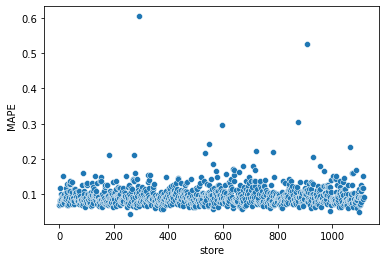

In [97]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## Total Performance

In [99]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns = {'index':'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$ 278,555,328.00"
1,worst_scenario,"R$ 277,815,047.01"
2,best_scenario,"R$ 279,295,630.85"


## Machine Learning Performance

In [100]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

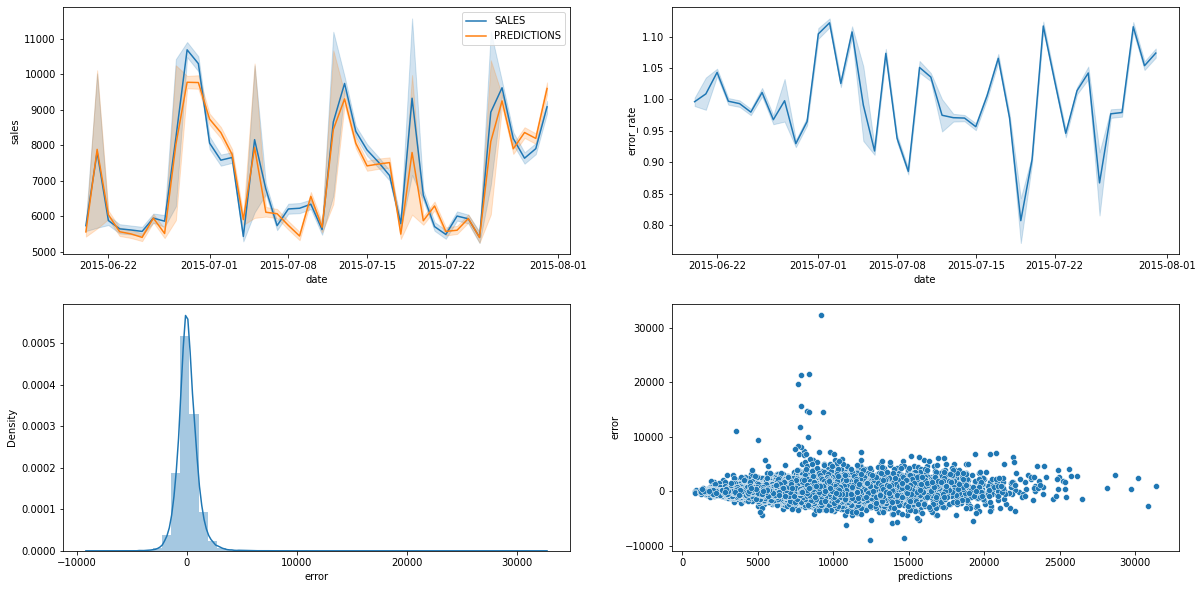

In [101]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])

# Deploy Model to Production

In [102]:
# Saving the model
pickle.dump(model_xgb_tunned, open('../models/model_rossman.pkl','wb'))

## Rossman Class

In [103]:
import pickle
import inflection
import pandas as pd
import numpy as np

class Rossmann(object):
    
    def __init__(self):
        self.home_path = '/home/brunods/Documents/portfolio_github/the_rossman_projects/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + '/parameters/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + '/parameters/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + '/parameters/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + '/parameters/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + '/parameters/store_type_scaler.pkl', 'rb'))
        

    def data_cleaning(self, df_raw):
        
        # List old cols names
        cols_old = df_raw.columns.to_list()
        #cols_old.remove('Sales')
        #cols_old.remove('Customers')

        # Lambda function 
        snakecase = lambda x : inflection.underscore(x)

        # List of new cols name
        cols_new = list(map(snakecase, cols_old))

        # Rename
        df_raw.columns = cols_new

        # Change columns date dtype to datetime
        df_raw['date'] = pd.to_datetime(df_raw['date'])

        # competition_distance - Probably the NAs values are store that dont have a near competition or its to far lets fill them with a high number
        df_raw['competition_distance'] = df_raw['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) else x )

        # competition_open_since_month - Lets fill with the month of column date in this way we will be able to calculate(Feature Engineering) time related variables from it.
        df_raw['competition_open_since_month'] = df_raw.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

        # competition_open_since_year
        df_raw['competition_open_since_year'] = df_raw.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

        #  promo2_since_week
        df_raw['promo2_since_week'] = df_raw.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df_raw['promo2_since_year'] = df_raw.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1:'Jan', 2:'Fev',3:'Mar',4:'Abr',5:'Mai',6:'Jun',7:'Jul',8:'Ago',9:'Set',10:'Out',11:'Nov',12:'Dez',}

        df_raw['promo_interval'].fillna(0, inplace=True)
        df_raw['month_map'] = df_raw['date'].dt.month.map(month_map)

        df_raw['is_promo'] = df_raw[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        # competition_open_since variabels
        df_raw['competition_open_since_month'] = df_raw['competition_open_since_month'].astype(int)
        df_raw['competition_open_since_year'] = df_raw['competition_open_since_year'].astype(int)

        # promo2_since variables
        df_raw['promo2_since_week'] = df_raw['promo2_since_week'].astype(int)
        df_raw['promo2_since_year'] = df_raw['promo2_since_year'].astype(int)
        
        return df_raw
        
        
    def feature_engineering(self, df_feat):

        # year
        df_feat['year'] = df_feat['date'].dt.year

        # month
        df_feat['month'] = df_feat['date'].dt.month

        # day
        df_feat['day'] = df_feat['date'].dt.day

        # week of year
        df_feat['week_of_year'] = df_feat['date'].dt.isocalendar().week

        # year week
        df_feat['year_week'] = df_feat['date'].dt.strftime('%Y-%W')

        # competition since
        df_feat['competition_since'] = df_feat.apply(lambda x : datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'] , day=1 ), axis=1)
        df_feat['competition_time_month']=((df_feat['date'] - df_feat['competition_since'])/30).apply(lambda x: x.days).astype('int')

        # promo since
        df_feat['promo_since'] = df_feat['promo2_since_year'].astype(str) + '-' + df_feat['promo2_since_week'].astype(str) 
        df_feat['promo_since'] = df_feat['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df_feat['promo_time_week'] = ((df_feat['date'] - df_feat['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df_feat['assortment']=df_feat['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df_feat['state_holiday']=df_feat['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

        df_feat = df_feat.loc[(df_feat['open'] != 0), :]

        #'customers' - Modelo em separado para prever a quantidade de clientes daqui a 6 meses, sem isso não conseguimos usar
        cols_drop = ['open', 'promo_interval', 'month_map']
        df_feat = df_feat.drop(cols_drop, axis=1)
        
        return df_feat

    def data_preparation(self, df5):

        # MinMaxScaler / RobustScaler
        #mms = MinMaxScaler(feature_range=(0,1))

        # competition distance, competition time month, promo time week - RobustScaler
        variaveis = ['competition_distance', 'competition_time_month', 'promo_time_week']

        for var in variaveis:
            df5[var] = self.competition_distance_scaler.fit_transform(np.array(df5[var]).reshape(-1,1))

        # year
        df5['year'] = self.year_scaler.fit_transform(np.array(df5['year']).reshape(-1,1))

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])


        # assortment - Ordinal Encoding
        assortment_dict = {'basic' : 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # response transf
        df5['sales'] = np.log1p(df5['sales'])

        # Nature TRansfomation due ciclical nature of variables
        clic_vars = ['day_of_week', 'day', 'month', 'week_of_year']


        for var in clic_vars:
            if var == 'month':
                df5[str(var)+'_sin'] = df5[var].apply( lambda x: np.sin(x *(2. * np.pi/12)))
                df5[str(var)+'_cos'] = df5[var].apply( lambda x: np.cos(x *(2. * np.pi/12)))

            elif var == 'day':
                df5[str(var)+'_sin'] = df5[var].apply( lambda x: np.sin(x *(2. * np.pi/30)))
                df5[str(var)+'_cos'] = df5[var].apply( lambda x: np.cos(x *(2. * np.pi/30)))

            elif var == 'day_of_week':
                df5[str(var)+'_sin'] = df5[var].apply( lambda x: np.sin(x *(2. * np.pi/7)))
                df5[str(var)+'_cos'] = df5[var].apply( lambda x: np.cos(x *(2. * np.pi/7)))

            else:
                df5[str(var)+'_sin'] = df5[var].apply( lambda x: np.sin(x *(2. * np.pi/52)))
                df5[str(var)+'_cos'] = df5[var].apply( lambda x: np.cos(x *(2. * np.pi/52)))
                
        # feature selection
        cols_selected = ['store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'day_sin',
                         'day_cos',
                         'month_cos',
                         'week_of_year_cos']
                
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        
        #prediction
        pred = model.predict(test_data)
        
        #join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## API Handler

In [107]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann import Rossmann

# loading model
home_path = '/home/brunods/Documents/portfolio_github/the_rossman_projects/'
pickle.load(open(home_path + '/models/model_rossman.pkl','rb'))

# INitialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossman_predict():
    test_json = request.get_json()
    if test_json:
        
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())       

        # Intantiate
        pipeline = Rossmann()

        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        #feature engineering
        df2 = pipeline.feature_engineering(df1)

        #data preparation
        df3 = pipeline.data_preparation(df2)

        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
    return df_response

if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.0.32:5000/ (Press CTRL+C to quit)


## API Tester

In [109]:
from flask import Flask, request, Response
import requests

# Merging store data and test data - all loaded in the section 1.0
df_test = test_df.merge(store_df, on='Store', how='left')
df_test.drop('Id', inplace=True, axis=1)

# chose store for prediction, remove closed days and nulls
df_test = df_test.loc[(df_test['Store'].isin([24,22,12])) & (df_test['Open']!=0) & (~df_test['Open'].isna()),:]

#Convvert Dataframe to json
#data = json.dumps(df_test.to_dict(orient = 'records'))
data = df_test.to_json(orient = 'records')

In [126]:
df_test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
7,12,4,2015-09-17,1.0,1,0,0,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
15,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
17,24,4,2015-09-17,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
863,12,3,2015-09-16,1.0,1,0,0,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
871,22,3,2015-09-16,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [144]:
# API call
#url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'http://192.168.0.32:5000/rossmann/predict'
url = 'https://rossmann-app.herokuapp.com/rossmann/predict' 
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print(f'Status Code: {r.status_code} ')

Status Code: 503 


In [130]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [131]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell R$ {:,.2f} in the next 6 weeks'.format( d2.loc[i, 'store'], d2.loc[i, 'prediction'] ))

Store number 12 will sell R$ 232,690.17 in the next 6 weeks
Store number 22 will sell R$ 154,656.13 in the next 6 weeks
Store number 24 will sell R$ 277,099.39 in the next 6 weeks
